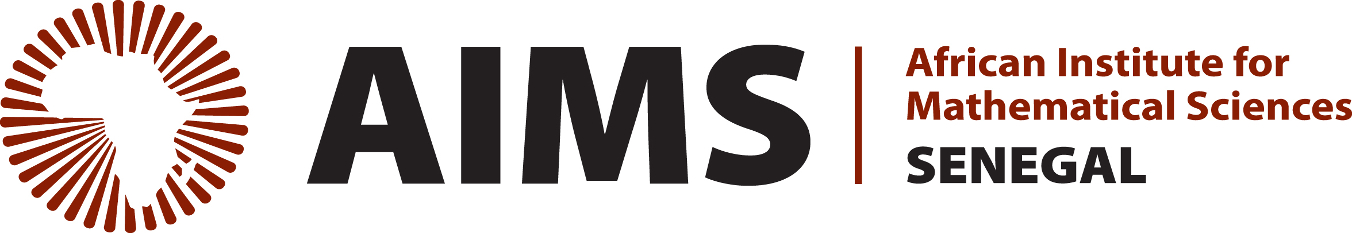
    
#    <center> <b> <span style="color:orange;" >  `AIMS THESIS 2022 : Optimal Trading Algorithms; a Machine Learning Approach ` </span> </b></center>

#### <center> <b> <span style="color:blue;"> Sandra Marion Kam Tsemo  (sandra.m.k.tsemo@aims-senegal.org) </span> </b></center>

#### <center> <b> <span style="color:blue;"> African Institute for Mathematical Sciences (AIMS), Senegal </span> </b></center>

#### <center> <b> <span style="color:blue;"> Supervised by: Professor Moustapha Pemy (mpemy@towson.edu) </span> </b></center>

#### <center> <b> <span style="color:blue;"> Towson University, USA </b></center>

## <center> <b> <span style="color:orange;"> Optimal VWAP with Apple Intraday data 10-12-2017 </span> </b></center>



In [118]:
# import librairies

import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats 
import warnings
warnings.filterwarnings('ignore')

In [119]:
# import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# import data
mydata = pd.read_csv("/content/drive/MyDrive/Data_project/AAPLIntradayOf10-12-2017.csv",index_col = "Trade Time", parse_dates= True)
# description of the top 5 values
mydata.head(5)

,Volume,Price
Trade Time,,
2017-10-12 09:33:00,665180,156.720
2017-10-12 09:33:00,692778,156.800
2017-10-12 09:33:00,703428,156.850
2017-10-12 09:34:00,733959,156.884
2017-10-12 09:34:00,757401,156.830


In [108]:
# description rows and columns
mydata.shape

(1597, 2)

In [109]:
# statistical description
mydata.describe()

,Volume,Price
count,1.597000e+03,1597.000000
mean,8.753011e+06,156.678089
std,3.456692e+06,0.315942
min,6.651800e+05,155.770000
25%,6.637113e+06,156.540000
50%,8.913852e+06,156.785000
75%,1.083822e+07,156.890000
max,1.636981e+07,157.330000


In [110]:
#Converting all values to float for easy 

for i in ["Volume","Price"]:
    mydata[i]=mydata[i].astype(float)
mydata.dtypes

Volume    float64
Price     float64
dtype: object

In [111]:
#Vissually show the stock historical Price and Volume data
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['Price'],name='Price USD ($)'),secondary_y=False)
fig.add_trace(go.Bar(x=mydata.index,y=mydata['Volume'],name='Volume'),secondary_y=True)
fig.show()

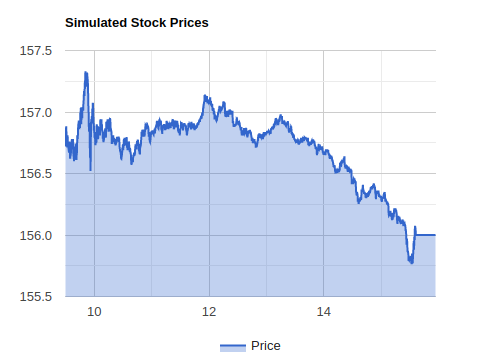


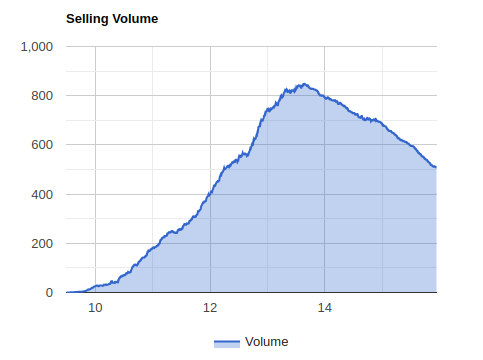

#### Market vwap
$VWAP(\pi) = \dfrac{\sum v_k x_k}{\sum v_k} , ∀ k \in \{0,...,N\}$

In [112]:
# implementation market vwap
def marketVwap(mydata):
        mydata['TradedValue']  = mydata['Volume']*mydata['Price']
        mydata['CumVolume'] = mydata['Volume'].cumsum()
        mydata['CumTradedValue'] = mydata['TradedValue'].cumsum()
        mydata['VWAP'] = mydata['CumTradedValue'] / (mydata['CumVolume'])
        return mydata
        
mydata = mydata.groupby('Trade Time').apply(marketVwap)

In [113]:
# description of the top 5 values
mydata.head(5)

,Volume,Price,TradedValue,CumVolume,CumTradedValue,VWAP
Trade Time,,,,,,
2017-10-12 09:33:00,665180.0,156.720,1.042470e+08,665180.0,1.042470e+08,156.720000
2017-10-12 09:33:00,692778.0,156.800,1.086276e+08,1357958.0,2.128746e+08,156.760813
2017-10-12 09:33:00,703428.0,156.850,1.103327e+08,2061386.0,3.232073e+08,156.791247
2017-10-12 09:34:00,733959.0,156.884,1.151464e+08,733959.0,1.151464e+08,156.884000
2017-10-12 09:34:00,757401.0,156.830,1.187832e+08,1491360.0,2.339296e+08,156.856576


In [114]:
# visually market vwap
from scipy.interpolate import interp1d
from dataclasses import dataclass
#Market VWAP
import plotly.graph_objects as go
from plotly.subplots import make_subplots
mydata = mydata[1400:1450]
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['VWAP'],name='Market VWAP'),secondary_y=False)
fig.show()

### Model vwap
$VWAP(\pi) = \dfrac{\sum m_k x_k}{\sum m_k} , ∀ k \in \{0,...,N\}$

### Dynamic Stock price

\\begin{equation}
\begin{cases}
x_{k+1}=x_k+x_k \mu \tau +\sigma x_k \xi_k\sqrt{\tau} + \lambda m_k\\
x_0=x,
\end{cases}
\end{equation}


where  $  \xi_k \sim \mathcal{N}(0,1)$,  $ \text{        }∀ k \in \{0,...,N\}$

#####Calibration of parameters **stock return** ($\mu$) and **volatility ***($\sigma$) using time series

In [121]:
# Calibration of stock return 𝜇 = r
mydata['Stock_return'] = (mydata['Price'] / mydata['Price'].shift(1)) - 1
mydata.head(5)

,Volume,Price,Stock_return
Trade Time,,,
2017-10-12 09:33:00,665180,156.720,NaN
2017-10-12 09:33:00,692778,156.800,0.000510
2017-10-12 09:33:00,703428,156.850,0.000319
2017-10-12 09:34:00,733959,156.884,0.000217
2017-10-12 09:34:00,757401,156.830,-0.000344


In [124]:
# most recent stock return value
sreturn = mydata['Stock_return'][3]
print('Recent stock return value is : r = ', sreturn)

Recent stock return value is : r =  0.00021676761236855135


In [125]:
#Stock Historical Return
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['Stock_return'],name='test'),secondary_y=False)
fig.show()

In [126]:
# Calibration of stock return 𝜎 = sigma
mydata['Volatility'] = np.sqrt(np.abs(mydata['Stock_return']))
mydata.head(5)

,Volume,Price,Stock_return,Volatility
Trade Time,,,,
2017-10-12 09:33:00,665180,156.720,NaN,NaN
2017-10-12 09:33:00,692778,156.800,0.000510,0.022593
2017-10-12 09:33:00,703428,156.850,0.000319,0.017857
2017-10-12 09:34:00,733959,156.884,0.000217,0.014723
2017-10-12 09:34:00,757401,156.830,-0.000344,0.018553


In [127]:
# most recent volatility value
sigma = mydata['Volatility'][3]
print('Recent volatility value is : sigma = ', sigma)

Recent volatility value is : sigma =  0.014723029999580636


In [128]:
#Stock Historical Return
import plotly.graph_objects as go
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=mydata.index,y=mydata['Volatility'],name='test'),secondary_y=False)
fig.show()

In [91]:
# most recent price value
x = mydata['Price'][0]
print('Recent price value is : x = ', x)

Recent price value is : x =  156.72


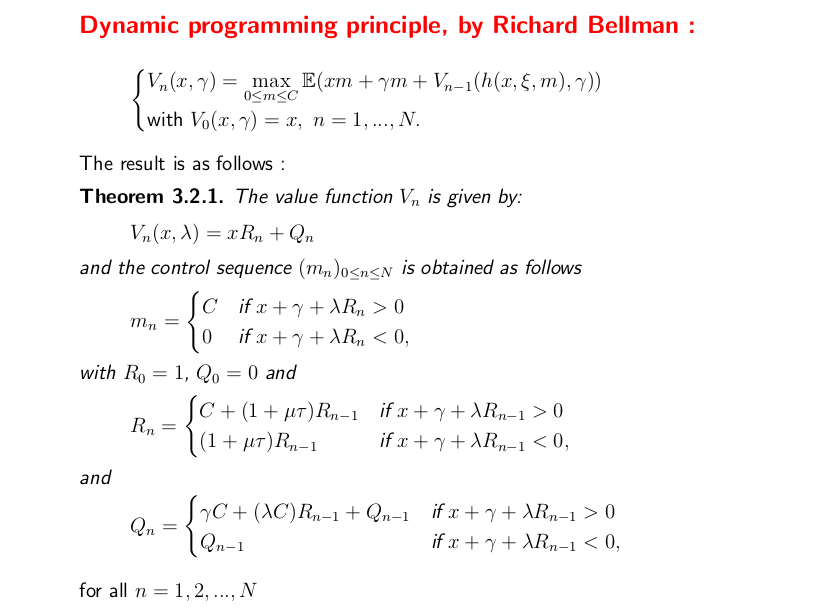

In [129]:
# Define all initial values
M = 1000000  # Total Shares prices
N = 100   # Number of steps.
T = 1   # Expiration time (one day usually)
x = 156.72  # recent value of stock price
r = mu = 0.0002167676 # stock return
sigma =  0.0147230299 # Volatility
lam = 0.001 #  minimising impact and λ ∈ (−1, 1)
dt = tau = T/N  # time unit --------- Constructing a trajectory of E is then equivalent to sampling from successive 
                #intervals over a uniform mesh {0, dt, 2dt, 3dt, . . . , Ndt}, where dt = 1/N, and N is the number of steps.

C = 1000 # Maximum Sells
gam = 0.4 # Lagrange multiplier
R0 = 1 # initial condition of the function Rn
Q0 = 0 # initial condition of the function Qn

In [102]:
# implementation model vwap and plot market vwap and model vwap together
def Number_Shares (R0, Q0, x, N) :
  list_=[]
  R = R0
  Q = Q0
  for k in range (N) :
    if x+gam+lam*R > 0 :
      R = C + (1 + r * dt)*R
      Q = gam * C + lam * C * R + Q
      m_n = C
    else :
      R = (1 + r * dt)*R
      Q = Q
      m_n = 0
    list_.append(m_n)
  return list_

Num_Share = Number_Shares (R0, Q0, x, N)

In [103]:
def StockPrice (x, N) :
  list_=[]
  S = x
  for k in range (N) :
    E = np.random.normal(0, 1)
    S = (1 + r * dt + sigma * E * m.sqrt(dt))*x + lam * Num_Share
    list_.append(x)
  return list_

In [96]:
def modelVwap(mydata):
        mydata['TradedValue']  = Num_Share*mydata['Price']
        mydata['CumTradedValue'] = mydata['TradedValue'].cumsum()
        mydata['VWAP_t'] = mydata['CumTradedValue'] / M
        return mydata
mydata = mydata.groupby('Trade Time').apply(modelVwap)

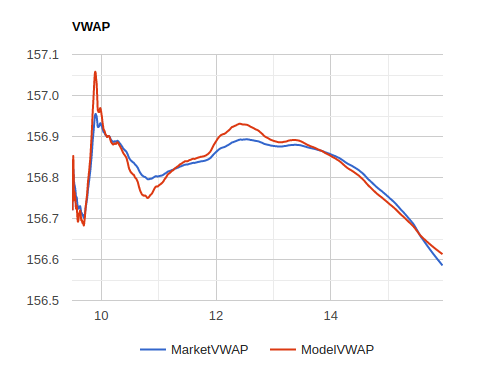

### Comment :

> We observe that on average, our optimal VWAP algorithm is efficient because it beats the market algorithm. And we see that the total volume sold so far is: 978212.434833485. What we propose as a next step is to hold 0 shares at the recommended price of 156.034799304963.







#### End Optimal vwap algorithm.



